# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
 -1
  1
  1
  1
  1
 -1
  1
  1
  ⋮
  1
 -1
 -1
  1
 -1
  1
 -1
 -1
  1

### We create a function to visualize the data

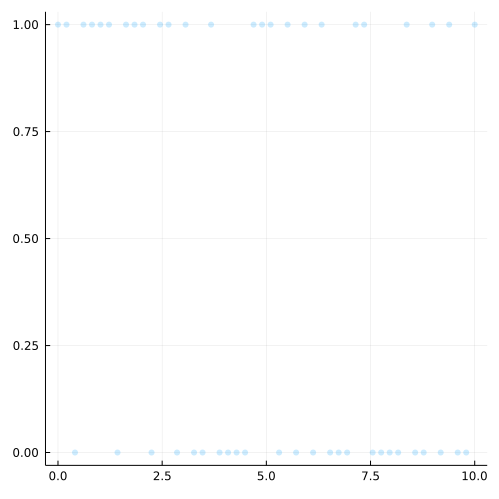

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.866422 seconds (1.86 M allocations: 98.347 MiB, 99.56% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [1.0083296964347717, 1.0318130314819642, 1.0590374436388494, 1.0854432051026288, 1.1054657680217872, 1.1142920208126967, 1.1080023223178395, 1.0837144147441922, 1.0400363187789754, 0.9765159908315907  …  0.8723809718062312, 0.8510027517141798, 0.8186778882109592, 0.7793328933163008, 0.7387931746916491, 0.7041909494145909, 0.682451884875776, 0.6793510924950453, 0.6966964567836195, 0.7317327754266628], θ = [0.23077088948616375, 0.22995177571220765, 0.22898770767921978, 0.228038349174362, 0.2273094578538002, 0.2269857504881124, 0.22721657702812179, 0.22810092279307048, 0.22966218529443796, 0.23186140131803035  …  0.23526520373809148, 0.23593043596068058, 0.23691322706520196, 0.2380706896362683, 0.2392170183424923, 0.24015688343547656, 0.24072863810906844, 0.24080899316272975, 0.240355646947

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:22
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:13
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:28
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:06
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:53
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:33
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:26
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:23
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:21
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.1269863913559589, -0.09457629532437917, -0.0020847203426401784, 0.06095626692833722, 0.16919295593799089, 0.23638088061859863, 0.30239544102794536, 0.3854979842678669, 0.4231434002329182, 0.4555998205251278  …  -0.1634996741534568, -0.1007323509129987, -0.06740112265374776, -0.04702278808761384, -0.04775052909709676, -0.0068658047054294125, 0.028471460771925305, 0.08747105187555632, 0.14972349256467, 0.22130296480480027]]
 [[0.5501385647157971, 0.6751161049647909, 0.742241486674062, 0.7556018449106794, 0.7550717075101749, 0.7986136319507233, 0.8021174030896884, 0.8376439171600116, 0.9057495562973084, 0.9826923176622884  …  -0.578493348895609, -0.527928299573083, -0.4198055908634705, -0.2543177156378378, -0.05956808571050193, 0.08829637567850646, 0.158319718841889, 0.20799325522350803, 0.17031455102362197, 0.16119565335839434]]
 [[1.2424868263542865, 1.4370041984009987, 1.5171550486624672, 1.5539290731819992, 1.5269507371800435, 1.4953

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

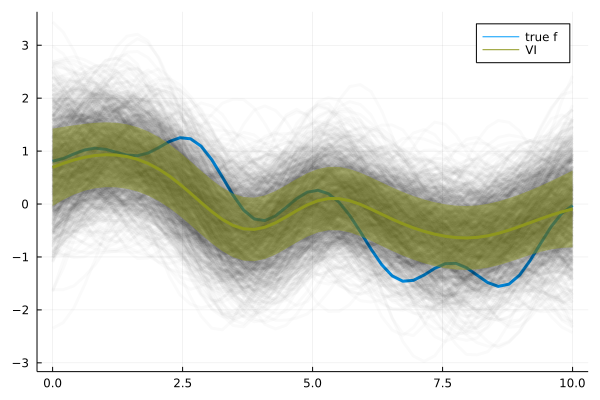

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

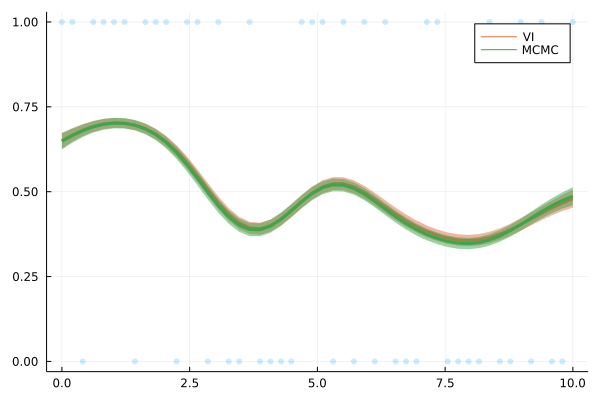

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*